# Загрузка библиотек

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans, SpectralClustering, AgglomerativeClustering, Birch
from sklearn.metrics import silhouette_score

# Определение констант

In [2]:
data_path = 'data/'

goods = ['Бензак', 'Броня и одежда', 'Жидкости для тачки', 'Медпрепараты и еда',
         'Модификации тачки', 'Оружие', 'Патроны', 'Солярка', 'Съедобный хлам',
         'Хлам', 'Ядер-Кола']

random_state = 1543

# Загрузка данных

In [3]:
shops = pd.read_parquet(data_path + 'shops.parquet')
sales_pivoted = pd.read_csv('sales_pivoted.csv')
sales_pivoted['date'] = pd.to_datetime(sales_pivoted['date'])

In [4]:
sales_pivoted.head()

,date,shop_id,Бензак,Броня и одежда,Жидкости для тачки,Медпрепараты и еда,Модификации тачки,Оружие,Патроны,Солярка,Съедобный хлам,Хлам,Ядер-Кола,number_of_counters
0,2146-01-01,0,10537.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,26.0,NaN,4.0
1,2146-01-02,0,14107.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,5.0,NaN,4.0
2,2146-01-03,0,16092.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,18.0,17.0,NaN,4.0
3,2146-01-04,0,18050.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,30.0,70.0,NaN,4.0
4,2146-01-05,0,18456.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.0,6.0,NaN,4.0


# Подготовка данных к кластеризации

In [5]:
# Разделим количество проданных товаров на количество работающих прилавков
for good in goods:
    sales_pivoted[good] = sales_pivoted[good]/sales_pivoted['number_of_counters']
sales_pivoted = sales_pivoted.drop('number_of_counters', axis = 'columns')

In [6]:
# Добавим информацию о времени года
sales_pivoted['season'] = (sales_pivoted['date'].dt.month%12 + 3)//3
# Удалим информацию о кконкретной дате
sales_pivoted = sales_pivoted.drop('date', axis = 'columns')

In [7]:
# Посчитаем средние продажи в каждом времени года
mean_sales = sales_pivoted.groupby(['shop_id', 'season']).mean()
mean_sales = mean_sales.reset_index()
mean_sales = pd.pivot_table(mean_sales, index = 'shop_id', columns = ['season'])

In [8]:
mean_sales.head()

Бензак                                        Броня и одежда  \
season             1            2            3            4              1   
shop_id                                                                      
0        4111.489597  3571.061141  4152.630435  4126.006868       0.602273   
1        2131.113087  2255.507609  2862.492391  2761.797222       0.742222   
2        2689.147651  2458.390110  2853.618207  2933.961538       4.119128   
3        7861.261745  7296.433424  7933.891304  8430.595304       0.796053   
4        3633.142207  2992.049306  3039.308041  3346.777137       2.115362   

                                      Жидкости для тачки            ...  \
season          2         3         4                  1         2  ...   
shop_id                                                             ...   
0        0.583333       NaN       NaN           5.000000  3.750000  ...   
1        0.852055  1.069474  0.784524           4.200000  3.866667  ...   
2        5.982044  7.744565  9.912088           5.087500  4.336957  ...   
3        0.746377  0.692029  0.726667           7.689655  9.413551  ...   
4        1.561278  1.957394  2.079506           3.763799  3.604215  ...   

        Съедобный хлам                  Хлам                                   \
season               3          4          1          2          3          4   
shop_id                                                                         
0                  NaN        NaN   5.070000   4.434211        NaN        NaN   
1             8.352174   5.794320   2.921622   2.518095   2.955752   3.171759   
2            51.302989  41.435440  14.137755  10.786313  14.927989  15.497238   
3            15.531250  10.116022   6.289370   6.815789   7.690909   7.250000   
4            47.335012  40.198458  12.495526   9.957971  10.806393  11.436859   

         Ядер-Кола                                   
season           1          2          3          4  
shop_id                                              
0              NaN        NaN        NaN        NaN  
1              NaN        NaN        NaN        NaN  
2        11.988255  13.489011  17.201087  19.739011  
3              NaN        NaN        NaN   1.250000  
4        22.175466  19.869354  21.669024  24.757433  

[5 rows x 44 columns]

In [9]:
# Посчитаем долю средних продаж для каждого товара в каждом времени года
def calc_shares(x):
    sums = x.sum(axis = 'columns')
    for col in x:
        x[col] = x[col]/sums
    return x
mean_rates = mean_sales.groupby(level = [1], axis = 1).apply(calc_shares)

In [10]:
# Приведем все полученные приведем к отрезу [0; 1]
# Иначе кластеризации, основанные на евклидовом расстоянии, будут учитывать только долю продаж бензина,\
# т.к. она в десятки раз выше доли продаж остальных товаров
scaler = MinMaxScaler()
scaled = pd.DataFrame(scaler.fit_transform(mean_rates), columns = mean_rates.columns)
# Заменим пропущенные значения нулями(будем считать, что если нет информации о продажах товара, то его не продавали)
scaled = scaled.fillna(0)

# Кластеризация

В качестве метрики качества кластеризации я буду использовать [коэффициент силуэта](https://en.wikipedia.org/wiki/Silhouette_(clustering)).
Коэффициент силуэта для конкретной точки расчитывается как\
$\frac{B-A}{max(B,A)}$\
Где B - среднее расстояние от точки до точек ближайшего кластера. A - среднее расстояние от точки до точек кластера, которому данная точка принадлежит.\
Значения усредняются.\
Чем выше данная метрика - тем лучше выполнена кластеризация.\
Однако, я не будем полностью полагаться на данную метрику при оценивании качества кластеризации. В первую очередь, я хочу получить адекватное количество кластеров, которые можно адекватно проинтерпретировать и извлечь из этого какую-то ценную для бизнеса информацию.\
Также необходимо понимать, что значения всех метрик качества кластеризации завязано на выбранном признаковом пространстве, поэтому нельзя полностью полагаться на данные метрики

In [11]:
def clust_info(scaled, cl):
    print('Количество магазинов в каждом кластере')
    print(pd.Series(cl.labels_).value_counts())
    print('Коэффициент силуэта:', silhouette_score(scaled, cl.labels_))

Кластеризация с помощью k-means

In [12]:
n_clusters = 4
print('Количество кластеров:', n_clusters)
cl = KMeans(n_clusters = n_clusters, random_state = random_state)
cl.fit(scaled)
clust_info(scaled, cl)

Количество кластеров: 4
Количество магазинов в каждом кластере
2    410
0    249
1     96
3     90
dtype: int64
Коэффициент силуэта: 0.26473137687896153


Я выбрал этот алгоритм кластеризации с данными параметрами по совокупности признаков:
1. Адекватное количество кластеров (4). Их возможно адекватно проинтепретировать и объяснить их различие бизнесу.
2. Адекватное количество магазинов в кластерах (90+). Имеется смысл извлекать такие кластеры, так как они образуют большие, достаточно значимые группы для бизнеса.

При остальных методах кластеризации получалось либо низкое значение коэффициента силуэта, при данном или большем количестве кластеров, либо получались кластеры с маленьким количеством магазинов (1-10). Такие маленькие кластеры нет смысла интерпетировать, потому что бизнесу нерационально планировать отдельную стратегию для столь маленьких групп магазинов.

# Интерпретация полученных кластеров

In [13]:
cl = KMeans(n_clusters = 4, random_state = random_state)
cl.fit(scaled)
mean_rates['cluster'] = cl.labels_
mean_rates_clusters = mean_rates.groupby('cluster').mean().reset_index()

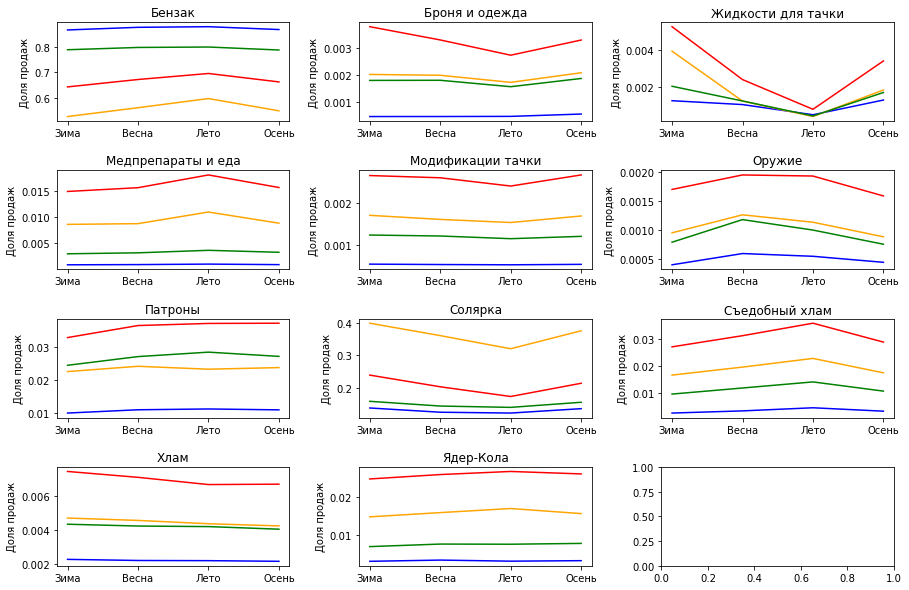

In [14]:
fig, axs = plt.subplots(4, 3, figsize = (15, 10))
plt.subplots_adjust(wspace = 0.3, hspace = 0.5)
row = 0
col = 0
for good in goods:
    for cluster,color in zip([0, 1, 2 , 3], ['blue', 'orange', 'green', 'red']):
        data = mean_rates_clusters[good].iloc[cluster]
        sns.lineplot(x = data.index, y = data.values, color = color, ax = axs[row][col])
        axs[row][col].set_xlabel('')
        axs[row][col].set_ylabel('Доля продаж')
        axs[row][col].set_title(good)
        axs[row][col].set_xticks(ticks = [1, 2, 3, 4])
        axs[row][col].set_xticklabels(labels = ['Зима', 'Весна', 'Лето', 'Осень'])
    
    if col == 2:
        row = row+1
        col = 0
    else:
        col = col+1

Синий кластер:
1. Самая большая доля продаж бензака.
2. Почти полное отсутствие сезонности во всех категориях. Лишь доля продаж жидкостей для тачек падает летом (как и во всех остальных кластерах)

Красный кластер:
1. Преобладают продажи товаров, не относящихся к категории "Топливо" (Бензак, солярка)
2. Яркая сезонность долей продаж почти всех товаров. Доля продаж брони, одежды и модификаций для тачки резко проседают летом, в то время как доли продаж съедобного хлама и медпрепаратов с едой сильно растут летом

Желтый кластер:

1. Самая высокая доля продажи солярки среди всех кластаеров. Летом доля продаж солярки падает.
2. Летом растет доля продаж бензака

Зеленый кластер:
1. Большая доля продаж бензака, но при этом меньше, чем в синем кластере. Из этого следуют большие доли продаж остальных товаров.

Скорее всего, магазины синего кластера посещают люди на легковых автомобилях (т.к. высока доля продаж бензака), которые не имеют нужды в каких-либо товарах, кроме бензака.

Магазины зеленого кластера посещают примерно такие же люди, но при этом они больше интересуются остальными товарами.

Магазины желтого кластера посещают водители грузовых автомобилей (высока доля продаж солярки). При этом летом доля таких водителей снижается и эти магазины начинает посещать большее количество людей на легковых автомобилях.

Магазины красного кластера посещают люди на легковых автомобилях, сильно заинтересованные в нетопливных товарах. Возможно, это происходит из-за того, что через эти магазины проезжают люди, которым нужны эти товары, но при этом они либо не имеют возможности заехать в другие магазины, либо решают сэкономить время, купив топливо и другие товары в одном магазине.